# Graph Coarsening on Cora Dataset using Local Variation Algorithms

## Import

In [1]:
import os
import sys
import numpy as np

# pygsp
from pygsp import graphs

# scipy
import scipy as sp

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# graph coarsening - Loukas 2020
from graphcoarsening.graph_coarsening.coarsening_utils import *
from graphcoarsening.graph_coarsening.graph_utils import *

# datasets
data_path = os.path.abspath(os.path.join("..", "data"))
if data_path not in sys.path:
    sys.path.append(data_path)
from cora.load_cora import load_cora_dataset

# utils
from utils.split_dataset import *
from utils.visualization import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


Using device: cpu


In [2]:
# load dataset
NODE_IDS, FEATURES, LABELS, EDGES_IDX, IDX_MAP = load_cora_dataset(log_info=False)

## GNN

In [3]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(nfeat, nhid)
        self.conv2 = GCNConv(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
def create_pyg_data(features, edges_idx, labels):
    x = torch.FloatTensor(features.astype(np.float32))
    edge_index = torch.LongTensor(edges_idx.T)  # expects (2, num_edges)
    y = torch.LongTensor(labels)
    
    edge_index = to_undirected(edge_index)
    
    return Data(x=x, edge_index=edge_index, y=y)


def train_gnn(model: nn.Module, optimizer: optim.Optimizer, data: Data, train_idx, val_idx, epochs=200):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    data = data.to(next(model.parameters()).device)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # train
        output = model(data.x, data.edge_index)
        loss_train = F.nll_loss(output[train_idx], data.y[train_idx])
        loss_train.backward()
        optimizer.step()
        
        # validation
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            loss_val = F.nll_loss(output[val_idx], data.y[val_idx])
            pred_val = output[val_idx].max(1)[1]
            acc_val = accuracy_score(data.y[val_idx].cpu().numpy(), pred_val.cpu().numpy())
        
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())
        val_accuracies.append(acc_val)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {loss_train:.4f}, '
                  f'Val Loss: {loss_val:.4f}, Val Acc: {acc_val:.4f}')
    
    return train_losses, val_losses, val_accuracies

def evaluate_model(model: nn.Module, data: Data, test_idx, log_info=True):
    """Evaluate the model on test set."""
    model.eval()
    data = data.to(next(model.parameters()).device)
    
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        pred_test = output[test_idx].max(1)[1]
        acc_test = accuracy_score(data.y[test_idx].cpu().numpy(), pred_test.cpu().numpy())
        
        if log_info:
            print(f'\nTest Accuracy: {acc_test:.4f}')
            print('\nClassification Report:')
            print(classification_report(
                data.y[test_idx].cpu().numpy(), pred_test.cpu().numpy())
            )

    return acc_test, pred_test

## main

### train model and training parameters

[[ 402  163]
 [ 659  163]
 [1696  163]
 ...
 [2258 1887]
 [1887 1902]
 [1686  837]]

Starting training...
Epoch 000, Train Loss: 1.9303, Val Loss: 1.7769, Val Acc: 0.4085
Epoch 010, Train Loss: 0.6772, Val Loss: 0.6505, Val Acc: 0.8392
Epoch 020, Train Loss: 0.3209, Val Loss: 0.3882, Val Acc: 0.8669
Epoch 030, Train Loss: 0.2153, Val Loss: 0.3766, Val Acc: 0.8706
Epoch 040, Train Loss: 0.1817, Val Loss: 0.3770, Val Acc: 0.8669
Epoch 050, Train Loss: 0.1573, Val Loss: 0.3945, Val Acc: 0.8632
Epoch 060, Train Loss: 0.1500, Val Loss: 0.4005, Val Acc: 0.8651
Epoch 070, Train Loss: 0.1377, Val Loss: 0.4015, Val Acc: 0.8614
Epoch 080, Train Loss: 0.1265, Val Loss: 0.4040, Val Acc: 0.8632
Epoch 090, Train Loss: 0.1289, Val Loss: 0.4140, Val Acc: 0.8595
Epoch 100, Train Loss: 0.1226, Val Loss: 0.4205, Val Acc: 0.8577
Epoch 110, Train Loss: 0.1124, Val Loss: 0.4210, Val Acc: 0.8614
Epoch 120, Train Loss: 0.1057, Val Loss: 0.4206, Val Acc: 0.8688
Epoch 130, Train Loss: 0.1073, Val Loss: 0.4420, 

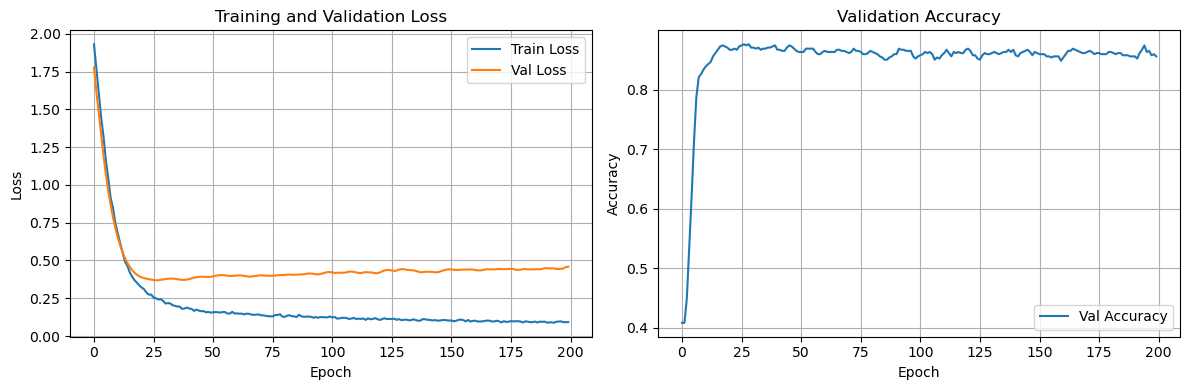

In [5]:
torch.manual_seed(1)
np.random.seed(1)
label_encoder = LabelEncoder()

# load dataset and preprocess
LABELS_ENCODED = label_encoder.fit_transform(LABELS)
data = create_pyg_data(FEATURES, EDGES_IDX, LABELS_ENCODED).to(device)
print(EDGES_IDX)

# create train, validation, and test splits
train_idx, val_idx, test_idx = create_train_val_test_split(data.num_nodes)
train_idx = torch.LongTensor(train_idx).to(device)
val_idx = torch.LongTensor(val_idx).to(device)
test_idx = torch.LongTensor(test_idx).to(device)

# create GNN model
nfeat = data.num_node_features  # 1433
nhid = 32
nclass = len(torch.unique(data.y))  # 7
dropout = 0.5
wd = 5e-4
lr = 0.01
model = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# train
print("\nStarting training...")
train_losses, val_losses, val_accuracies = train_gnn(
    model, optimizer, data, train_idx, val_idx, epochs=200
)

plot_training_curves(train_losses, val_losses, val_accuracies)

## evaluate

In [6]:
print("\nEvaluating on test set...")
test_acc, test_pred = evaluate_model(model, data, test_idx)
print(f"Test accuracy: {test_acc:.4f}")


Evaluating on test set...

Test Accuracy: 0.8600

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        49
           1       0.90      0.95      0.92        97
           2       0.86      0.91      0.88       156
           3       0.87      0.85      0.86        80
           4       0.91      0.82      0.87        51
           5       0.84      0.89      0.86        36
           6       0.75      0.70      0.73        74

    accuracy                           0.86       543
   macro avg       0.86      0.85      0.85       543
weighted avg       0.86      0.86      0.86       543

Test accuracy: 0.8600


## Create PyGSP Graph

In [7]:
def create_pygsp_graph(edges, num_nodes) -> graphs.Graph: 
    # adjacency matrix
    adj_matrix = sp.sparse.coo_matrix(
        (np.ones(len(edges)),
        (edges[:, 0], edges[:, 1])), 
        shape=(num_nodes, num_nodes)
    )
    adj_matrix = adj_matrix + adj_matrix.T
    adj_matrix.data = np.ones(len(adj_matrix.data))

    # pygsp graph
    G = graphs.Graph(adj_matrix)
    G.compute_laplacian()
    G.set_coordinates()
    
    return G

## Apply coarsening by Loukas

In [8]:
def apply_graph_coarsening(G: graphs.Graph, method='variation_neighborhoods', ratio=0.5, K=3):
    """
    Output:
      - C: coarsening matrix (n, N)
      - Gc: coarsened graph (n, n)
      - Call: all coarsened graphs (levels, n_l, N)
      - Gall: all original graphs (levels, n_l, n_l)
    """
    
    available_methods = ['variation_neighborhoods', 'variation_edges', 'variation_cliques', 'heavy_edge', 'algebraic_JC', 'affinity_GS', 'kron'] 
    if method not in available_methods:
        raise ValueError(f"Unknown coarsening method: {method}. Method must be one of {available_methods}.")
    
    print(f"Applying graph coarsening with method: {method}")

    C, Gc, Call, Gall = coarsen(G, K=K, method=method, r=ratio)

    print(f"Original graph: {G.N} nodes, {G.Ne} edges")
    print(f"Coarsened graph: {Gc.N} nodes, {Gc.Ne} edges")
    print(f"Reduction ratio: {G.N / Gc.N:.2f}")
    
    return C, Gc, Call, Gall

In [9]:
def get_coarsened_edges_and_features(C, edges_idx, features):
    """
    Coarsen edges and features based on the coarsening matrix C;
    the feature matrix (N x D) is made by summing up features from nodes that are coarsened into the same supernode.

    Output:
      - edges_idx_coarsened: coarsened edges index (num_edges, 2)
      - features_coarsened: coarsened features (num_nodes_coarsened, num_features)
    """

    idx_map = {}
    features_coarsened = np.zeros((C.shape[0], features.shape[1]), dtype=np.float32)
    for supernode, node in zip(*C.nonzero()):
        idx_map[node] = supernode
        features_coarsened[supernode] += features[node]
    
    edges_idx_coarsened = []
    for edge in edges_idx:
        u, v = edge[0], edge[1]
        if idx_map[u] != idx_map[v]:
            edges_idx_coarsened.append((idx_map[u], idx_map[v]))
    edges_idx_coarsened = np.array(edges_idx_coarsened)
    
    return edges_idx_coarsened, features_coarsened

In [ ]:
G_original = create_pygsp_graph(EDGES_IDX, len(NODE_IDS))

method = 'variation_neighborhoods'

C, Gc, Call, Gall = apply_graph_coarsening(G_original, method=method, ratio=0.5, K=50)

Applying graph coarsening with method: variation_neighborhoods
Original graph: 2708 nodes, 5278 edges
Coarsened graph: 1354 nodes, 2891 edges
Reduction ratio: 2.00


In [17]:
# visualize_coarsening_results(G_original, Gc, method_name=method)
# visualize_graph_statistics(G_original, Gc, method)

## predict on coarsened graph

In [15]:
edges_idx_coarsened, features_coarsened = get_coarsened_edges_and_features(C, EDGES_IDX, FEATURES)
data_coarsened = create_pyg_data(features_coarsened, edges_idx_coarsened, np.zeros(features_coarsened.shape[0]))

full_mask = [i for i in range(C.shape[0])]
_, pred_coarsened = evaluate_model(model, data_coarsened, full_mask, log_info=False)

pred_fine = np.zeros(len(NODE_IDS), dtype=np.int64)
for supernode, node in zip(*C.nonzero()):
    pred_fine[node] = pred_coarsened[supernode]

accuracy_score(pred_fine, LABELS_ENCODED)

0.8836779911373708